# Fremont Bridge Bicycle Traffic Forecasting

Project analyzes and forecasts bicycle traffic on the Fremont Bridge using time series data. It loads and preprocesses data from 'fremont-bridge.csv', visualizes daily bicycle crossings, and performs time series analysis. The project utilizes Facebook's Prophet library to create a forecasting model that accounts for yearly and weekly seasonality. Finally, it generates and visualizes predictions for the next 365 days, showing trend and seasonality components.

Dataset: https://www.kaggle.com/datasets/gauravduttakiit/fremont-bridge/code

Example Solution: https://thecleverprogrammer.com/2020/05/08/data-science-project-on-time-series/

Hugging Face: https://huggingface.co/spaces/alperugurcan/bicycle-traffic-forecast

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

In [30]:
df = pd.read_csv('fremont-bridge.csv', parse_dates=['Date'], index_col='Date') # parse_dates: Convert the 'Date' column to datetime format, index_col: Set the 'Date' column as the index of the DataFrame


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45984 entries, 2012-10-03 00:00:00 to 2017-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   West    45976 non-null  float64
 1   East    45976 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB


In [32]:
df['Total'] = df['West'] + df['East'] # Create a new column 'Total' by summing the 'West' and 'East' columns

In [33]:
df.head()

,West,East,Total
Date,,,
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


In [34]:
df = df.resample('D').sum()  # Resample to daily data

In [35]:
df.head()

,West,East,Total
Date,,,
2012-10-03,1760.0,1761.0,3521.0
2012-10-04,1708.0,1767.0,3475.0
2012-10-05,1558.0,1590.0,3148.0
2012-10-06,1080.0,926.0,2006.0
2012-10-07,1191.0,951.0,2142.0


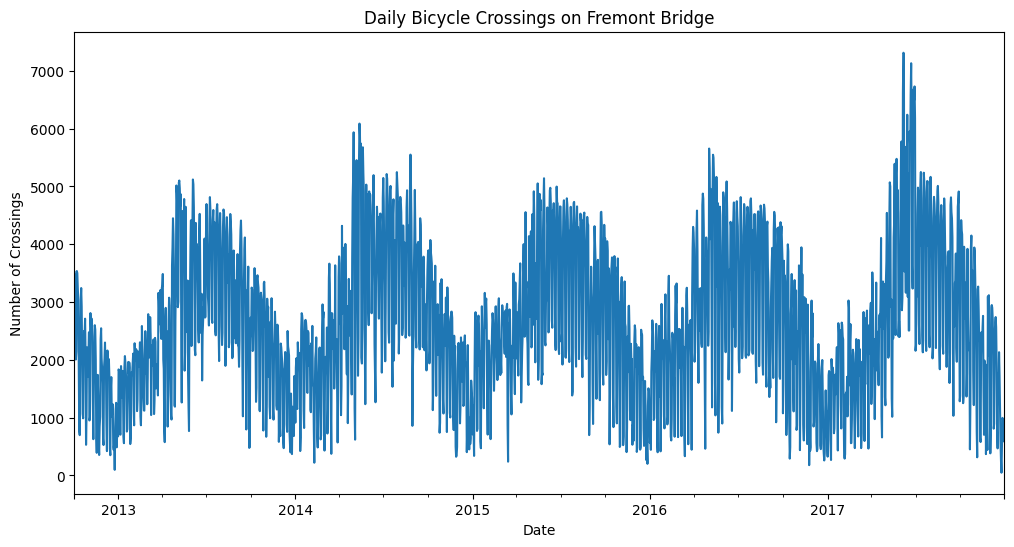

In [36]:
plt.figure(figsize=(12, 6))
df['Total'].plot()
plt.title('Daily Bicycle Crossings on Fremont Bridge')
plt.ylabel('Number of Crossings')
plt.show()

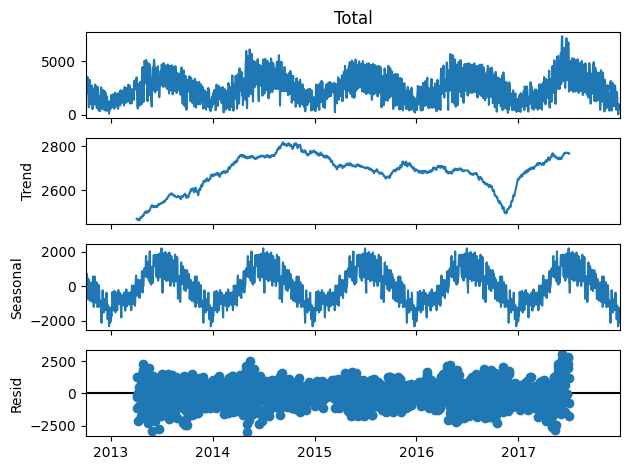

In [39]:
# Time Series Decomposition
decomposition = seasonal_decompose(df['Total'], model='additive', period=365)  # Perform time series decomposition
decomposition.plot()  # Plot the decomposition results
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()  # Display the plot

In [40]:
train = df['Total'][:int(0.8*len(df))]  # Create training set with first 80% of data
test = df['Total'][int(0.8*len(df)):]  # Create test set with last 20% of data

In [44]:
# Fit SARIMA model
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))  # Initialize SARIMA model
results = model.fit()  # Fit the model to the training data

c:\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
# Forecast
forecast = results.get_forecast(steps=len(test))  # Generate forecast for the test period
forecast_ci = forecast.conf_int() # Calculate confidence intervals

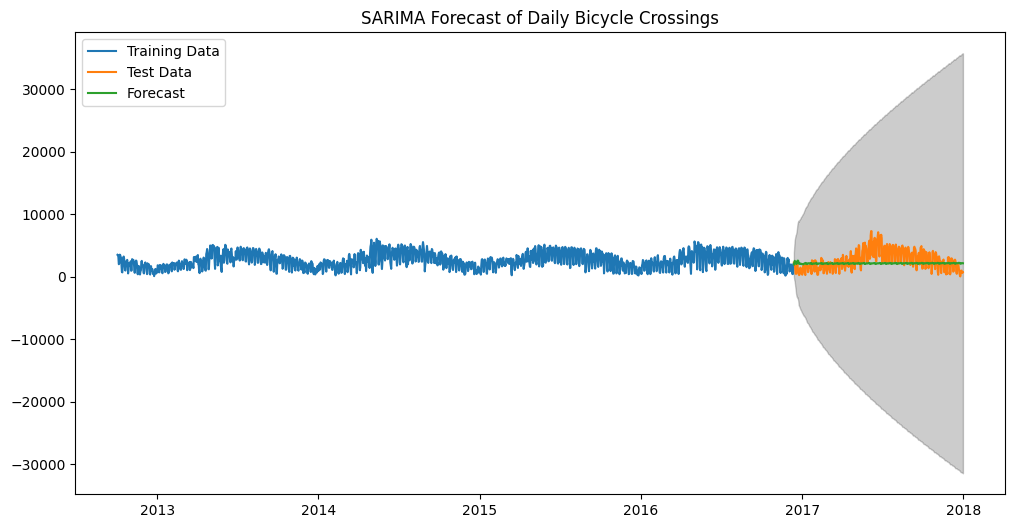

In [46]:
# Plot results
plt.figure(figsize=(12, 6))  # Create a new figure with specified size
plt.plot(train.index, train, label='Training Data')  # Plot training data
plt.plot(test.index, test, label='Test Data')  # Plot test data
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast')  # Plot forecast
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=0.2)  # Plot confidence intervals
plt.title('SARIMA Forecast of Daily Bicycle Crossings')  # Set the plot title
plt.legend()  # Add legend to the plot
plt.show()  # Display the plot

In [47]:
# Evaluate model
mse = mean_squared_error(test, forecast.predicted_mean)  # Calculate Mean Squared Error
rmse = np.sqrt(mse)  # Calculate Root Mean Squared Error
print(f'Root Mean Squared Error: {rmse}')  # Print the RMSE

Root Mean Squared Error: 1637.4137451067852


# Prophet Model


In [48]:
from prophet import Prophet

In [49]:
df = pd.read_csv('fremont-bridge.csv', parse_dates=['Date'])  # Load CSV file and parse dates
df['y'] = df['West'] + df['East']  # Calculate total crossings and store in 'y' column for Prophet
df = df.rename(columns={'Date': 'ds'})  # Rename Date column to ds for Prophet
df = df.resample('D', on='ds').sum().reset_index()  # Resample to daily data

In [51]:
df.head()

,ds,West,East,y
0,2012-10-03,1760.0,1761.0,3521.0
1,2012-10-04,1708.0,1767.0,3475.0
2,2012-10-05,1558.0,1590.0,3148.0
3,2012-10-06,1080.0,926.0,2006.0
4,2012-10-07,1191.0,951.0,2142.0


In [52]:
# Create and fit the model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)  # Initialize Prophet model
model.fit(df[['ds', 'y']])  # Fit the model to the data


00:13:35 - cmdstanpy - INFO - Chain [1] start processing
00:13:35 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
# Make future predictions
future = model.make_future_dataframe(periods=365)  # Create dataframe for future dates (1 year)
forecast = model.predict(future)  # Generate predictions

C:\Users\alperugurcan\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\alperugurcan\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


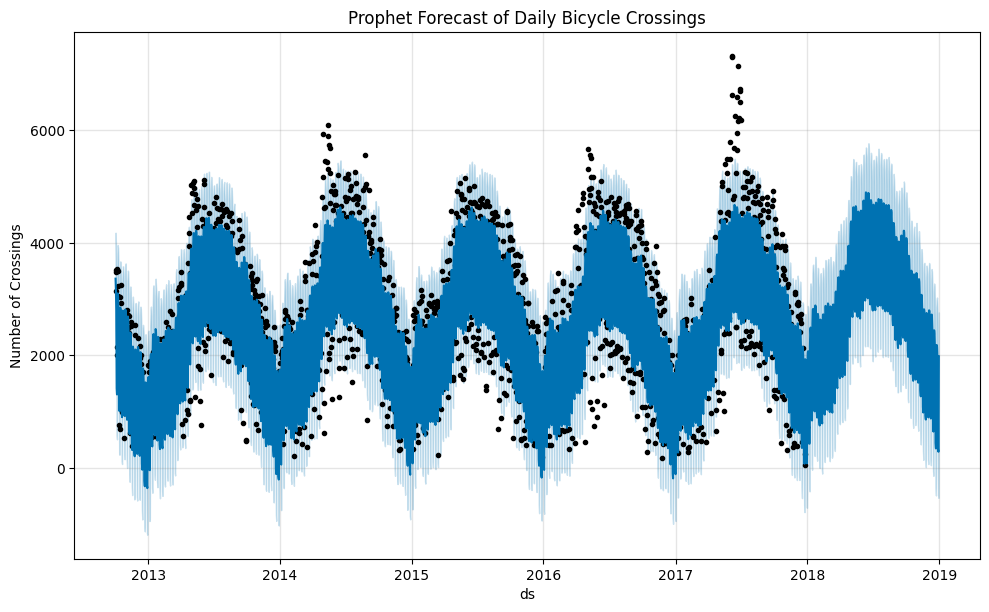

In [54]:
# Plot results
fig = model.plot(forecast)  # Plot forecast
plt.title('Prophet Forecast of Daily Bicycle Crossings')
plt.ylabel('Number of Crossings')
plt.show()

C:\Users\alperugurcan\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\alperugurcan\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\alperugurcan\AppData\Roaming\Python\Python310\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pytho

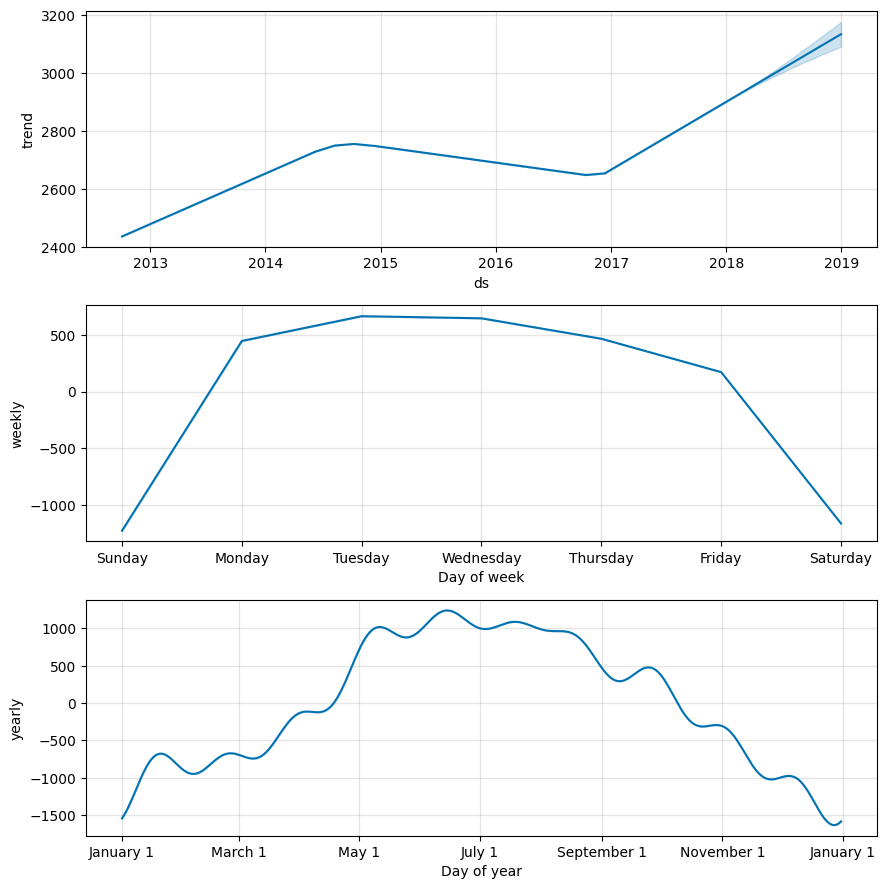

In [55]:
# Plot components
fig = model.plot_components(forecast)  # Plot trend, yearly and weekly seasonality
plt.show()

In [56]:
# Print future predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())  # Print last 5 predictions

             ds         yhat   yhat_lower   yhat_upper
2276 2018-12-27  1960.506535  1128.628901  2821.677326
2277 2018-12-28  1665.140159   819.586228  2503.746474
2278 2018-12-29   338.662173  -481.667315  1126.006430
2279 2018-12-30   289.549466  -528.750846  1123.763174
2280 2018-12-31  1983.773399  1101.791970  2761.615990


In [57]:
np.__version__

'1.26.4'